<a href="https://colab.research.google.com/github/srikantharun/Solar-Irradiance-Forecase-Himawari9/blob/main/solar-cloud-cover-estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install google-cloud-storage rasterio geopandas numpy opencv-python matplotlib pysteps pvlib
!apt-get install ffmpeg  # Required for saving the animation as MP4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.4/604.4 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 27.7 MB/s eta 0:00:00
  Created wheel for pysteps: filename=pysteps-1.17.0-cp311-cp311-linux_x86_64.whl size=1609433 sha256=3f07b5e13c2002413c048c96f152d2166a9004e7ff77222b8a03920fd3e676b9
  Stored in directory: /root/.cache/pip/wheels/aa/9b/67/3922a07bedde090af2938337e632f0b5329fde6fb30c006f79
Successfully built pysteps
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [5]:
from google.cloud import storage
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta
import os
import pysteps
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.nowcasts import steps
import pvlib
import pandas as pd


# Coimbatore coordinates (latitude, longitude)
coimbatore_coords = (11.0168, 76.9558)  # lat, lon
# Define a bounding box around Coimbatore (approx 0.5 degrees ~ 55 km)
bbox = {
    "min_lat": coimbatore_coords[0] - 0.25,
    "max_lat": coimbatore_coords[0] + 0.25,
    "min_lon": coimbatore_coords[1] - 0.25,
    "max_lon": coimbatore_coords[1] + 0.25
}

Pysteps configuration file found at: /usr/local/lib/python3.11/dist-packages/pysteps/pystepsrc



In [6]:
import requests
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from IPython.display import Video, display
import matplotlib.animation as animation
import pysteps
from pysteps import io, motion, nowcasts
from pysteps.utils import conversion, transformation

# Define Coimbatore coordinates and bounding box
COIMBATORE_COORDS = (11.0168, 76.9558)  # lat, lon
COIMBATORE_BBOX = {
    "min_lat": COIMBATORE_COORDS[0] - 0.25,
    "max_lat": COIMBATORE_COORDS[0] + 0.25,
    "min_lon": COIMBATORE_COORDS[1] - 0.25,
    "max_lon": COIMBATORE_COORDS[1] + 0.25
}

# Define the South Asia region extent (used by Himawari SE4 imagery)
SOUTH_ASIA_EXTENT = (70.0, 0.0, 100.0, 30.0)  # [lon_min, lat_min, lon_max, lat_max]

def find_coimbatore_in_himawari(image_array, south_asia_extent=SOUTH_ASIA_EXTENT,
                              coimbatore_bbox=COIMBATORE_BBOX):
    """
    Locate the Coimbatore region within the Himawari SE4 image array.

    Args:
        image_array (np.ndarray): The image array from Himawari
        south_asia_extent (tuple): Extent of the full image (lon_min, lat_min, lon_max, lat_max)
        coimbatore_bbox (dict): Bounding box for Coimbatore region

    Returns:
        tuple: (slice_y, slice_x) for indexing the Coimbatore region in the image
    """
    # Extract dimensions of the image
    height, width = image_array.shape

    # Calculate conversion from lat/lon to pixel coordinates
    lon_min, lat_min, lon_max, lat_max = south_asia_extent
    lon_range = lon_max - lon_min
    lat_range = lat_max - lat_min

    # Convert Coimbatore bbox to pixel coordinates
    x_min = int((coimbatore_bbox["min_lon"] - lon_min) / lon_range * width)
    x_max = int((coimbatore_bbox["max_lon"] - lon_min) / lon_range * width)

    # Remember the y-axis is inverted (lat_max at the top)
    y_min = int((lat_max - coimbatore_bbox["max_lat"]) / lat_range * height)
    y_max = int((lat_max - coimbatore_bbox["min_lat"]) / lat_range * height)

    # Ensure pixel coordinates are within image bounds
    x_min = max(0, min(width-1, x_min))
    x_max = max(0, min(width-1, x_max))
    y_min = max(0, min(height-1, y_min))
    y_max = max(0, min(height-1, y_max))

    # Check if the box has a reasonable size (at least 20x20 pixels)
    if (x_max - x_min < 20) or (y_max - y_min < 20):
        print("Warning: The calculated Coimbatore region is too small. Using a larger area.")
        x_min = max(0, x_min - 10)
        x_max = min(width-1, x_max + 10)
        y_min = max(0, y_min - 10)
        y_max = min(height-1, y_max + 10)

    print(f"Coimbatore region in Himawari image: x={x_min}:{x_max}, y={y_min}:{y_max}")
    print(f"Region size: {x_max - x_min}x{y_max - y_min} pixels")

    return slice(y_min, y_max), slice(x_min, x_max)

def round_to_nearest_10_minutes(dt):
    """
    Round a datetime object to the nearest 10-minute interval.
    """
    minute = dt.minute
    rounded_minute = round(minute / 10) * 10
    if rounded_minute == 60:
        dt = dt.replace(minute=0) + timedelta(hours=1)
    else:
        dt = dt.replace(minute=rounded_minute)
    dt = dt.replace(second=0, microsecond=0)
    return dt

def download_latest_himawari_jpegs(num_images=3, hours_back=4):
    """
    Download the latest Himawari-9 JPEG files from JMA for the South Asia region.
    """
    base_url = "https://www.data.jma.go.jp/mscweb/data/himawari/"
    region = "se4"  # South Asia region
    band = "b03"  # Visible red band

    current_time = datetime.utcnow()
    start_time = current_time - timedelta(hours=hours_back)

    timestamps = []
    current_timestamp = current_time
    seen_timestamps = set()
    while current_timestamp >= start_time and len(timestamps) < num_images:
        rounded_timestamp = round_to_nearest_10_minutes(current_timestamp)
        timestamp_str = rounded_timestamp.strftime("%Y%m%d%H%M")
        if timestamp_str not in seen_timestamps:
            timestamps.append(rounded_timestamp)
            seen_timestamps.add(timestamp_str)
        current_timestamp -= timedelta(minutes=10)

    downloaded_files = []
    for i, timestamp in enumerate(timestamps[:num_images]):
        date_str = timestamp.strftime("%Y%m%d")
        time_str = timestamp.strftime("%H%M")

        current_date = datetime.utcnow().date()
        timestamp_date = timestamp.date()
        if timestamp_date == current_date:
            list_url = f"{base_url}list_se4.html"
        else:
            list_url = f"{base_url}list_se4_{date_str}.html"

        file_url = f"{base_url}img/{region}/{region}_{band}_{time_str}.jpg"
        local_filename = f"himawari_{date_str}_{time_str}.jpg"

        try:
            response = requests.get(file_url)
            if response.status_code == 200:
                with open(local_filename, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded: {local_filename} (from {file_url})")
                downloaded_files.append(local_filename)
            else:
                print(f"Failed to download {file_url} (Status code: {response.status_code})")
        except Exception as e:
            print(f"Error downloading {file_url}: {e}")
            continue

    if len(downloaded_files) < num_images:
        print("Warning: Could not download enough recent images.")
        print("The JMA website may not have updated files for the requested time range.")

    return downloaded_files

def process_jpeg_to_array(jpeg_file, crop_to_coimbatore=True):
    """
    Convert a JPEG file to a grayscale NumPy array for cloud cover analysis.
    Optionally crop to just the Coimbatore region.

    Args:
        jpeg_file (str): Path to the JPEG file
        crop_to_coimbatore (bool): Whether to crop to just the Coimbatore region

    Returns:
        np.ndarray: Grayscale array (0-1 range) representing the image
    """
    img = Image.open(jpeg_file).convert('L')
    img_array = np.array(img) / 255.0

    if crop_to_coimbatore:
        # Get the slice for the Coimbatore region
        y_slice, x_slice = find_coimbatore_in_himawari(img_array)

        # Crop the image to the Coimbatore region
        img_array = img_array[y_slice, x_slice]

        # Save a visualization of the cropped region
        if jpeg_file == "himawari_20250429_0140.jpg":  # First image in the sequence
            plt.figure(figsize=(8, 8))
            plt.imshow(img_array, cmap='gray')
            plt.title("Cropped Coimbatore Region")
            plt.colorbar(label='Cloud Reflectance')
            plt.savefig("coimbatore_region.png")
            plt.close()

    return img_array

def pysteps_analysis(tif_files, forecast_minutes=60, timestep=10, region_name="Coimbatore"):
    """
    Perform motion estimation and nowcasting using Pysteps.
    Specifically tailored for pysteps 1.17.0 with all known issues fixed.

    Args:
        tif_files (list): List of paths to .tif files.
        forecast_minutes (int): Total forecast duration in minutes.
        timestep (int): Time interval between forecast steps in minutes.
        region_name (str): Name of the region being analyzed (for logs)

    Returns:
        tuple: (motion_field, nowcast)
            - motion_field: The estimated motion field.
            - nowcast: The forecasted cloud field.
    """
    # Calculate number of forecast timesteps
    n_timesteps = forecast_minutes // timestep

    print(f"Using pysteps version: 1.17.0")
    print(f"Generating forecast for {region_name} region for {forecast_minutes} minutes with {n_timesteps} steps")

    # Load the .tif files into a 3D NumPy array (time, height, width)
    data_array = []
    for tif_file in tif_files:
        with rasterio.open(tif_file) as src:
            img = src.read(1)
            data_array.append(img)
    data_array = np.stack(data_array, axis=0)
    print(f"Loaded data array shape: {data_array.shape}")
    print(f"Data array min: {data_array.min()}, max: {data_array.max()}")

    # Ensure no NaN or infinite values
    data_array = np.nan_to_num(data_array, nan=0.0, posinf=1.0, neginf=0.0)

    # Calculate kmperpixel based on Coimbatore region geography
    # Estimate based on the size of the region (0.5° x 0.5°)
    # At latitude 11°N, 1° ≈ 111 km
    region_width_km = 0.5 * 111 * np.cos(np.radians(COIMBATORE_COORDS[0]))  # Adjust for latitude
    region_height_km = 0.5 * 111

    avg_km_per_pixel = (region_width_km / data_array.shape[2] +
                        region_height_km / data_array.shape[1]) / 2

    kmperpixel_estimate = avg_km_per_pixel
    print(f"Using estimated pixel size: {kmperpixel_estimate:.4f} km")

    # Estimate the motion field using Lucas-Kanade optical flow
    oflow_method = motion.get_method("lucaskanade")
    motion_field = oflow_method(data_array)
    print(f"Motion field shape: {motion_field.shape}")

    # Check motion field magnitude
    motion_magnitude = np.sqrt(motion_field[0]**2 + motion_field[1]**2)
    mean_magnitude = np.mean(motion_magnitude)
    max_magnitude = np.max(motion_magnitude)
    print(f"Motion magnitude - Mean: {mean_magnitude:.5f}, Max: {max_magnitude:.5f}")

    if max_magnitude < 1e-6:
        print("Warning: No significant motion detected. Using small random motion.")
        np.random.seed(42)
        motion_field[0] += np.random.normal(0, 0.001, motion_field[0].shape)
        motion_field[1] += np.random.normal(0, 0.001, motion_field[1].shape)

    # Get the steps nowcast method
    nowcast_method = nowcasts.get_method("steps")

    # For pysteps 1.17.0:
    # 1. 'timesteps' is required
    # 2. Need to disable mask_method to avoid precip_thr requirement
    # 3. Need to disable vel_pert_method or provide kmperpixel
    try:
        print("Trying with optimized parameters for pysteps 1.17.0...")
        nowcast = nowcast_method(
            data_array,
            motion_field,
            timesteps=n_timesteps,
            mask_method=None,  # Disable masking
            vel_pert_method=None,  # Disable velocity perturbation
            n_cascade_levels=6,
            ar_order=2,
            noise_method="nonparametric"
        )
    except Exception as e:
        print(f"Optimized parameters failed: {e}")
        print("Trying with kmperpixel specified...")
        try:
            nowcast = nowcast_method(
                data_array,
                motion_field,
                timesteps=n_timesteps,
                mask_method=None,
                kmperpixel=kmperpixel_estimate
            )
        except Exception as e2:
            print(f"Second attempt failed: {e2}")
            print("Trying with absolute minimal parameters...")
            try:
                nowcast = nowcast_method(
                    data_array,
                    motion_field,
                    timesteps=n_timesteps,
                    mask_method=None,
                    vel_pert_method=None
                )
            except Exception as e3:
                print(f"Minimal parameters failed: {e3}")
                # Last resort - implement a simple advection manually
                print("Implementing simple manual advection...")

                # Use the last frame as the starting point
                last_frame = data_array[-1]

                # Create a sequence of forecasts by advecting the last frame
                nowcast = []

                # Use a simple backward advection scheme
                y_indices, x_indices = np.mgrid[0:last_frame.shape[0], 0:last_frame.shape[1]]

                for t in range(1, n_timesteps + 1):
                    # Calculate displacement at each timestep
                    displacement_y = motion_field[0] * t
                    displacement_x = motion_field[1] * t

                    # Create new coordinates
                    coords_y = np.clip(y_indices - displacement_y, 0, last_frame.shape[0] - 1)
                    coords_x = np.clip(x_indices - displacement_x, 0, last_frame.shape[1] - 1)

                    # Simple nearest-neighbor interpolation
                    coords_y = np.floor(coords_y).astype(int)
                    coords_x = np.floor(coords_x).astype(int)

                    # Create advected frame
                    advected_frame = last_frame[coords_y, coords_x]
                    nowcast.append(advected_frame)

                # Stack the forecasts into a 3D array (time, height, width)
                nowcast = np.stack(nowcast, axis=0)

    print(f"Nowcast shape: {nowcast.shape}")

    # Ensure values stay in valid reflectance range
    nowcast = np.nan_to_num(nowcast, nan=0.0)
    nowcast = np.clip(nowcast, 0, 1)
    print(f"Final nowcast min: {nowcast.min()}, max: {nowcast.max()}")

    return motion_field, nowcast

def assess_cloud_impact_on_solar(nowcast, threshold=0.3, impact_threshold=0.25, timestep=10, region_name="Coimbatore"):
    """
    Analyze cloud cover forecasts to assess potential impacts on solar panel irradiance.

    Args:
        nowcast (np.ndarray): The nowcast data array (can be ensemble or single forecast)
        threshold (float): Cloud detection threshold (pixels above this value are clouds)
        impact_threshold (float): Percentage of area covered by clouds to trigger warning
        timestep (int): Time interval between forecast steps in minutes
        region_name (str): Name of the region being analyzed

    Returns:
        dict: Dictionary with impact assessment for each timestep
    """
    print(f"Analyzing potential cloud impacts on solar panel irradiance for {region_name}...")

    # Handle different nowcast formats (ensemble vs. single forecast)
    if nowcast.ndim == 4:  # Ensemble forecast
        if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble
            # Calculate mean across ensemble members
            forecast_data = np.nanmean(nowcast, axis=0)  # (timesteps, height, width)
        else:  # First dim is time
            # Calculate mean across ensemble members
            forecast_data = np.nanmean(nowcast, axis=1)  # (timesteps, height, width)
    else:
        forecast_data = nowcast  # Already single forecast

    # Handle NaN values
    forecast_data = np.nan_to_num(forecast_data, nan=0.0)

    # Initialize results
    impact_assessment = {}

    # Analyze each timestep
    for t in range(len(forecast_data)):
        # Get forecast for this timestep
        forecast_frame = forecast_data[t]

        # Calculate cloud cover percentage
        cloud_mask = forecast_frame > threshold
        coverage_percent = np.mean(cloud_mask) * 100

        # Determine impact level based on coverage
        if coverage_percent >= 75:
            impact_level = "Severe"
            impact_desc = "Major reduction in solar irradiance expected"
            color_code = "red"
        elif coverage_percent >= 50:
            impact_level = "High"
            impact_desc = "Significant reduction in solar irradiance expected"
            color_code = "orange"
        elif coverage_percent >= 25:
            impact_level = "Moderate"
            impact_desc = "Moderate reduction in solar irradiance expected"
            color_code = "yellow"
        elif coverage_percent >= 10:
            impact_level = "Low"
            impact_desc = "Minor reduction in solar irradiance possible"
            color_code = "blue"
        else:
            impact_level = "Minimal"
            impact_desc = "No significant impact on solar irradiance expected"
            color_code = "green"

        # Calculate time from now
        minutes_from_now = (t + 1) * timestep

        # Store results
        impact_assessment[t] = {
            "time_minutes": minutes_from_now,
            "cloud_coverage_percent": coverage_percent,
            "impact_level": impact_level,
            "description": impact_desc,
            "color_code": color_code,
            "exceeds_threshold": coverage_percent >= (impact_threshold * 100)
        }

    return impact_assessment

def generate_impact_notification(impact_assessment, region_name="Coimbatore"):
    """
    Generate notification messages based on impact assessment.

    Args:
        impact_assessment (dict): Assessment dictionary from assess_cloud_impact_on_solar
        region_name (str): Name of the region being analyzed

    Returns:
        tuple: (alert_message, detailed_forecast)
    """
    # Check if any timestep exceeds the impact threshold
    impact_timesteps = [t for t, data in impact_assessment.items()
                      if data["exceeds_threshold"]]

    if not impact_timesteps:
        alert_message = f"""
☀️ SOLAR IRRADIANCE ALERT: CLEAR CONDITIONS
Region: {region_name}
Status: No significant cloud coverage expected in the next hour.
Forecast: Optimal conditions for solar power generation.
"""
        detailed_forecast = "No significant cloud impacts expected in the forecast period."
        return alert_message, detailed_forecast

    # Find first impact time
    first_impact = min(impact_timesteps)
    first_impact_data = impact_assessment[first_impact]
    minutes_until_impact = first_impact_data["time_minutes"]

    # Find highest impact level
    highest_impact_level = max([data["impact_level"] for t, data in impact_assessment.items()
                              if t in impact_timesteps],
                             key=lambda x: ["Minimal", "Low", "Moderate", "High", "Severe"].index(x))

    # Create alert message
    if minutes_until_impact <= 20:
        timeframe = f"in the next {minutes_until_impact} minutes"
    else:
        timeframe = f"in approximately {minutes_until_impact} minutes"

    alert_message = f"""
☁️ SOLAR IRRADIANCE ALERT: CLOUD IMPACT EXPECTED
Region: {region_name}
Status: {highest_impact_level} impact on solar irradiance expected {timeframe}.
Forecast: Cloud coverage of {first_impact_data['cloud_coverage_percent']:.1f}% expected.
Action: Consider adjusting power management systems accordingly.
"""

    # Create detailed forecast table
    detailed_forecast = "Detailed cloud impact forecast:\n\n"
    detailed_forecast += "Time | Cloud Cover | Impact Level | Description\n"
    detailed_forecast += "-----|------------|--------------|-------------\n"

    for t in sorted(impact_assessment.keys()):
        data = impact_assessment[t]
        minutes = data["time_minutes"]
        coverage = data["cloud_coverage_percent"]
        impact = data["impact_level"]
        description = data["description"]

        detailed_forecast += f"+{minutes}min | {coverage:.1f}% | {impact} | {description}\n"

    return alert_message, detailed_forecast

def visualize_solar_impact(nowcast, impact_assessment, threshold=0.3, region_name="Coimbatore"):
    """
    Create a visualization showing cloud coverage and solar impact over time.

    Args:
        nowcast (np.ndarray): The nowcast data array
        impact_assessment (dict): Impact assessment dictionary
        threshold (float): Cloud detection threshold
        region_name (str): Name of the region being analyzed
    """
    # Prepare the data
    if nowcast.ndim == 4:  # Ensemble forecast
        if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble
            forecast_data = np.nanmean(nowcast, axis=0)  # (timesteps, height, width)
        else:
            forecast_data = np.nanmean(nowcast, axis=1)
    else:
        forecast_data = nowcast

    # Replace NaNs with zeros
    forecast_data = np.nan_to_num(forecast_data, nan=0.0)

    # Create a figure with two parts: cloud images and impact chart
    n_timesteps = len(forecast_data)
    fig, axs = plt.subplots(2, n_timesteps, figsize=(15, 8),
                           gridspec_kw={'height_ratios': [3, 1]})

    # Plot each timestep
    for t in range(n_timesteps):
        # Get data for this timestep
        forecast_frame = forecast_data[t]
        impact_data = impact_assessment[t]

        # Plot cloud image
        axs[0, t].imshow(forecast_frame, cmap='gray', vmin=0, vmax=1)
        axs[0, t].set_title(f"+{impact_data['time_minutes']} min")
        axs[0, t].axis('off')

        # Create cloud mask
        cloud_mask = forecast_frame > threshold
        coverage = impact_data['cloud_coverage_percent']

        # Add cloud coverage text
        axs[0, t].text(0.5, 0.05, f"Cloud: {coverage:.1f}%",
                     transform=axs[0, t].transAxes,
                     color='white', fontsize=10, ha='center',
                     bbox=dict(facecolor='black', alpha=0.5))

        # Plot impact level bar
        impact_level = impact_data['impact_level']
        color = impact_data['color_code']

        # Map impact level to a value (0-4)
        impact_map = {"Minimal": 0, "Low": 1, "Moderate": 2, "High": 3, "Severe": 4}
        impact_value = impact_map[impact_level]

        # Plot a colored bar for impact
        axs[1, t].bar(0, 1, color=color, width=0.5)
        axs[1, t].set_xlim(-0.5, 0.5)
        axs[1, t].set_ylim(0, 1)
        axs[1, t].text(0, 0.5, impact_level, ha='center', va='center',
                      color='black' if color in ['yellow', 'green'] else 'white',
                      fontweight='bold')
        axs[1, t].axis('off')

    # Add overall title
    plt.suptitle(f"Solar Panel Irradiance Impact Forecast for {region_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the figure
    plt.savefig(f"{region_name.lower()}_solar_impact_forecast.png", dpi=150)
    plt.close()

    print(f"Solar impact visualization saved as '{region_name.lower()}_solar_impact_forecast.png'")

def create_animation(nowcast, timestep=10, region_name="Coimbatore"):
    """
    Create an animation from the nowcast data.
    Enhanced to handle ensemble output from pysteps 1.17.0.

    Args:
        nowcast (np.ndarray): The nowcast data array.
        timestep (int): Time interval between forecast steps in minutes.
        region_name (str): Name of the region being analyzed

    Returns:
        matplotlib.animation.FuncAnimation: The animation object.
    """
    print(f"Nowcast array shape for animation: {nowcast.shape}")

    # First, handle NaN values
    nowcast = np.nan_to_num(nowcast, nan=0.0)

    # Handle different pysteps output formats
    # For pysteps 1.17.0, shape is typically (n_ens_members, n_timesteps, height, width)
    if nowcast.ndim == 4:
        print(f"Processing 4D nowcast array with shape {nowcast.shape}")

        # Check which dimension is ensemble and which is time
        if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble (more members than timesteps)
            n_ens = nowcast.shape[0]
            n_timesteps = nowcast.shape[1]
            print(f"Detected {n_ens} ensemble members and {n_timesteps} timesteps")

            # Calculate ensemble mean for each timestep
            nowcast_mean = np.mean(nowcast, axis=0)  # Average across ensemble members
            print(f"Created ensemble mean with shape {nowcast_mean.shape}")

            # Use the mean for animation
            nowcast_for_animation = nowcast_mean
        else:  # First dim might be time, second dim ensemble
            n_timesteps = nowcast.shape[0]
            n_ens = nowcast.shape[1]
            print(f"Detected {n_timesteps} timesteps and {n_ens} ensemble members")

            # Calculate ensemble mean for each timestep
            nowcast_mean = np.mean(nowcast, axis=1)  # Average across ensemble members
            print(f"Created ensemble mean with shape {nowcast_mean.shape}")

            # Use the mean for animation
            nowcast_for_animation = nowcast_mean
    else:
        # For 3D array, assume (time, height, width)
        nowcast_for_animation = nowcast

    print(f"Processed nowcast shape: {nowcast_for_animation.shape}")

    # Ensure value range and handle any remaining NaNs
    nowcast_for_animation = np.nan_to_num(nowcast_for_animation, nan=0.0)
    nowcast_for_animation = np.clip(nowcast_for_animation, 0, 1)

    print(f"Final animation data shape: {nowcast_for_animation.shape}")
    print(f"Min value: {nowcast_for_animation.min()}, Max value: {nowcast_for_animation.max()}")

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the first frame
    im = ax.imshow(nowcast_for_animation[0], cmap='gray', vmin=0, vmax=1)
    plt.colorbar(im, label='Cloud Reflectance')
    title = ax.set_title(f"{region_name} Cloud Cover Forecast (t=0 min)")

    # Add timestamp and region label
    timestamp = ax.text(0.01, 0.01, f"t=0 min", transform=ax.transAxes,
                         color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    region_label = ax.text(0.99, 0.01, f"{region_name}", transform=ax.transAxes,
                         color='white', fontsize=12, ha='right',
                         bbox=dict(facecolor='black', alpha=0.5))

    # Simple update function
    def update(frame):
        im.set_array(nowcast_for_animation[frame])
        title.set_text(f"{region_name} Cloud Cover Forecast (t={frame * timestep} min)")
        timestamp.set_text(f"t={frame * timestep} min")
        return [im, title, timestamp, region_label]

    # Create and save animation with minimal settings
    anim = animation.FuncAnimation(
        fig, update, frames=len(nowcast_for_animation), interval=500, blit=True
    )

    output_filename = f"{region_name.lower()}_cloud_cover_animation.mp4"
    print(f"Saving animation to '{output_filename}'...")
    try:
        anim.save(output_filename, fps=2, dpi=100)
        print("Animation saved successfully!")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Trying alternative approach...")

        # If animation saving fails, save individual frames as images
        os.makedirs(f"{region_name.lower()}_forecast_frames", exist_ok=True)
        for i in range(len(nowcast_for_animation)):
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.imshow(nowcast_for_animation[i], cmap='gray', vmin=0, vmax=1)
            plt.colorbar(ax.imshow(nowcast_for_animation[i], cmap='gray', vmin=0, vmax=1),
                        label='Cloud Reflectance')
            ax.set_title(f"{region_name} Cloud Cover Forecast (t={i * timestep} min)")
            plt.savefig(f"{region_name.lower()}_forecast_frames/frame_{i:02d}.png")
            plt.close(fig)
        print(f"Saved individual frames in '{region_name.lower()}_forecast_frames' directory")

    plt.close(fig)
    return anim

def main():
    region_name = "Coimbatore"

    # Download the latest Himawari-9 JPEG files
    print(f"Downloading the latest Himawari-9 JPEG images (past 4 hours)...")
    try:
        downloaded_files = download_latest_himawari_jpegs(num_images=3, hours_back=4)
        if len(downloaded_files) < 3:
            print("Not enough images downloaded for analysis.")
            return
        print("Downloaded files:", downloaded_files)
    except Exception as e:
        print(f"Error downloading images: {e}")
        return

    # Process JPEG files for cloud cover analysis, cropping to Coimbatore region
    print(f"Processing JPEG files for cloud cover analysis for {region_name} region...")
    image_arrays = []
    for jpeg_file in downloaded_files:
        img_array = process_jpeg_to_array(jpeg_file, crop_to_coimbatore=True)
        image_arrays.append(img_array)

    # Estimate cloud cover from the first image
    print(f"Estimating cloud cover for {region_name}...")
    first_image_array = image_arrays[0]

    # Simple cloud detection with fixed threshold
    cloud_mask = first_image_array > 0.3

    # Calculate cloud cover percentage
    cloud_fraction = np.mean(cloud_mask)
    print(f"Cloud cover over {region_name} region: {cloud_fraction * 100:.2f}%")

    # Visualize the initial cloud data
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud_mask, cmap='gray')
    plt.title(f"Cloud Data (First Image) - {region_name} Region")
    plt.colorbar(label='Cloud Mask Value')
    plt.axis('off')
    plt.savefig(f'{region_name.lower()}_cloud_mask.png')
    plt.close()

    # Convert arrays to .tif files for Pysteps analysis
    print("Converting arrays to .tif files for Pysteps analysis...")
    clipped_files = []
    for i, img_array in enumerate(image_arrays):
        output_filename = f"{region_name.lower()}_image{i+1}_clipped.tif"

        # Write the array to a .tif file (simplified version)
        with rasterio.open(
            output_filename,
            'w',
            driver='GTiff',
            height=img_array.shape[0],
            width=img_array.shape[1],
            count=1,
            dtype=img_array.dtype
        ) as dst:
            dst.write(img_array, 1)

        clipped_files.append(output_filename)
        print(f"Saved {output_filename}")

    # Use Pysteps for motion estimation and nowcasting
    print(f"Performing Pysteps analysis for {region_name}...")
    try:
        # Using optimized parameters for pysteps 1.17.0
        motion_field, nowcast = pysteps_analysis(
            clipped_files,
            forecast_minutes=60,
            timestep=10,
            region_name=region_name
        )
    except Exception as e:
        print(f"Error in Pysteps analysis: {e}")
        print("Specific error:", str(e))
        print("Ensure pysteps is correctly installed.")
        return

    # Visualize the motion field
    plt.figure(figsize=(10, 5))
    step = 5  # Sample every 5th pixel for denser vectors in the smaller region
    y_indices, x_indices = np.mgrid[0:motion_field[0].shape[0]:step, 0:motion_field[0].shape[1]:step]
    plt.imshow(first_image_array, cmap='gray')
    plt.quiver(
        x_indices, y_indices,
        motion_field[1][::step, ::step],
        motion_field[0][::step, ::step],
        color='red', alpha=0.7
    )
    plt.title(f"Cloud Movement Direction - {region_name}")
    plt.axis('off')
    plt.savefig(f'{region_name.lower()}_motion_field.png')
    plt.close()

    # Assess potential impact on solar panel irradiance
    print(f"\nAssessing potential impact on solar panel irradiance for {region_name}...")
    impact_assessment = assess_cloud_impact_on_solar(
        nowcast,
        threshold=0.3,
        impact_threshold=0.25,
        region_name=region_name
    )

    # Generate notification
    alert_message, detailed_forecast = generate_impact_notification(impact_assessment, region_name=region_name)

    # Print the notification
    print("\n" + "="*60)
    print(alert_message)
    print("="*60)
    print("\n" + detailed_forecast)

    # Create impact visualization
    visualize_solar_impact(nowcast, impact_assessment, region_name=region_name)

    # Create regular animation
    print(f"Creating visualizations for {region_name}...")
    try:
        # Enhanced animation function that handles ensemble output
        anim = create_animation(nowcast, timestep=10, region_name=region_name)
        print(f"Animation saved as '{region_name.lower()}_cloud_cover_animation.mp4'")

        # Check if we have ensemble output (4D array)
        if nowcast.ndim == 4:
            print(f"Detected ensemble output. Creating ensemble visualizations for {region_name}...")
            visualize_ensemble(nowcast, timestep=10, max_members=6)
            print(f"Ensemble visualizations saved in '{region_name.lower()}_ensemble_forecast' directory")
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        print(f"Nowcast shape: {nowcast.shape}")
        try:
            min_val = np.nanmin(nowcast)
            max_val = np.nanmax(nowcast)
        except:
            min_val = "Error calculating"
            max_val = "Error calculating"
        print(f"Nowcast min/max values: {min_val}, {max_val}")

        # Save individual frames as fallback
        try:
            print("Attempting to save individual frames as fallback...")
            if nowcast.ndim == 4:
                # Take mean across ensemble dimension
                if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble
                    mean_nowcast = np.nanmean(nowcast, axis=0)
                else:  # First dim is time
                    mean_nowcast = np.nanmean(nowcast, axis=1)
            else:
                mean_nowcast = nowcast

            # Replace NaNs with zeros
            mean_nowcast = np.nan_to_num(mean_nowcast, nan=0.0)

            # Save frames
            os.makedirs(f"{region_name.lower()}_forecast_frames", exist_ok=True)
            for i in range(len(mean_nowcast)):
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.imshow(mean_nowcast[i], cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"{region_name} Cloud Cover Forecast (t={i * 10} min)")
                plt.savefig(f"{region_name.lower()}_forecast_frames/frame_{i:02d}.png")
                plt.close(fig)
            print(f"Saved individual frames in '{region_name.lower()}_forecast_frames' directory")
        except Exception as e2:
            print(f"Fallback frame saving also failed: {e2}")

    print(f"Analysis complete for {region_name}. Check output files for results.")

# Call the main function
if __name__ == "__main__":
    main()

Downloaded: himawari_20250429_0730.jpg (from https://www.data.jma.go.jp/mscweb/data/himawari/img/se4/se4_b03_0730.jpg)
Downloaded: himawari_20250429_0720.jpg (from https://www.data.jma.go.jp/mscweb/data/himawari/img/se4/se4_b03_0720.jpg)
Downloaded: himawari_20250429_0710.jpg (from https://www.data.jma.go.jp/mscweb/data/himawari/img/se4/se4_b03_0710.jpg)
Downloaded files: ['himawari_20250429_0730.jpg', 'himawari_20250429_0720.jpg', 'himawari_20250429_0710.jpg']
Processing JPEG files for cloud cover analysis for Coimbatore region...
Coimbatore region in Himawari image: x=124:154, y=365:395
Region size: 30x30 pixels
Coimbatore region in Himawari image: x=124:154, y=365:395
Region size: 30x30 pixels
Coimbatore region in Himawari image: x=124:154, y=365:395
Region size: 30x30 pixels
Estimating cloud cover for Coimbatore...
Cloud cover over Coimbatore region: 21.56%
Converting arrays to .tif files for Pysteps analysis...
Saved coimbatore_image1_clipped.tif
Saved coimbatore_image2_clipped.ti

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Extrapolation complete and precipitation fields aligned.
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | -0.078547     | -0.098359     |
-----------------------------------------
| 2     | 0.542192      | 0.631601      |
-----------------------------------------
| 3     | 0.396503      | 0.413660      |
-----------------------------------------
| 4     | 0.176627      | 0.147551      |
-----------------------------------------
| 5     | 0.128783      | 0.059498      |
-----------------------------------------
| 6     | 0.134565      | 0.067403      |
-----------------------------------------
****************************************
* AR(p) parameters for cascade levels: *
****************************************
-------------------------------------------

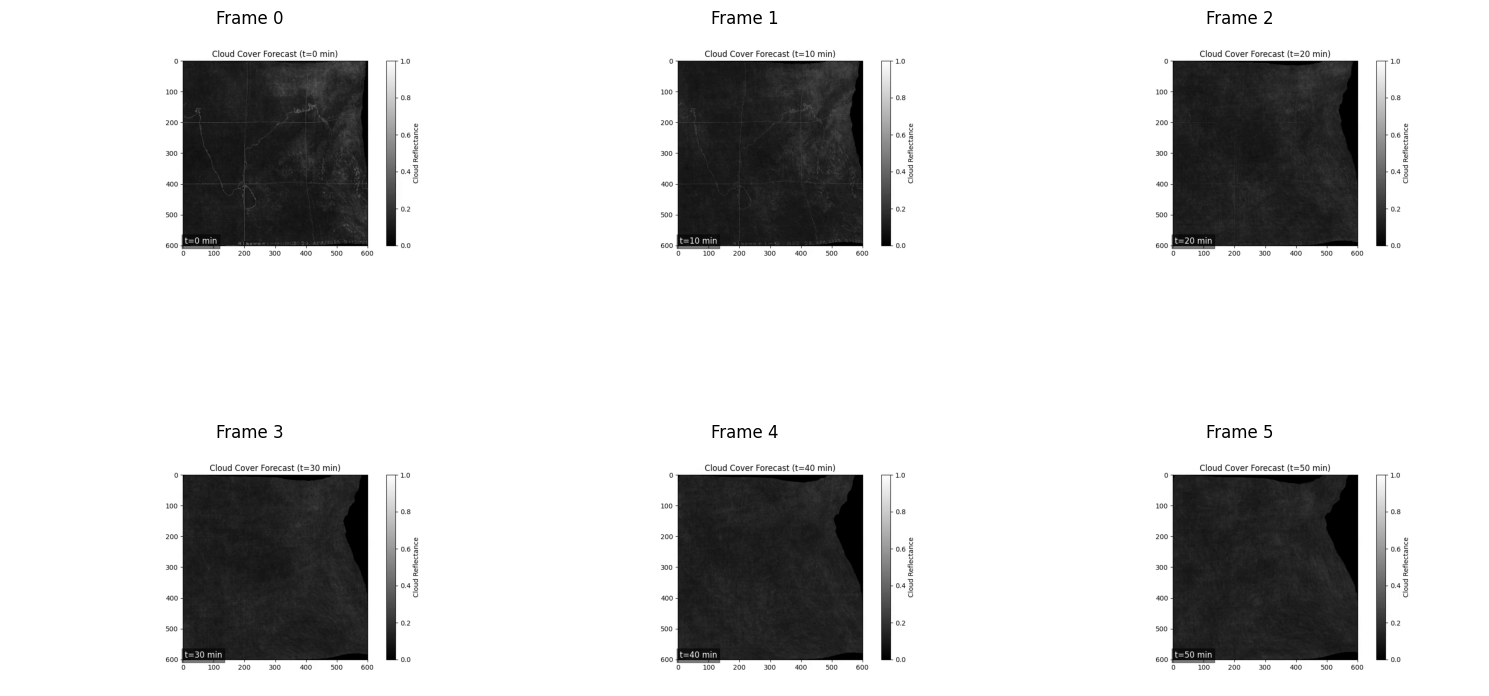

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_video_frames(video_path, num_frames=6):
    """Show sample frames from a video file."""
    cap = cv2.VideoCapture(video_path)

    # Get total frame count
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frames to sample
    if total_frames <= num_frames:
        frames_to_sample = range(total_frames)
    else:
        frames_to_sample = np.linspace(0, total_frames-1, num_frames, dtype=int)

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Sample and display frames
    for i, frame_idx in enumerate(frames_to_sample):
        if i >= len(axes):
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}")
            axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(frames_to_sample), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    cap.release()

# Show sample frames
show_video_frames('cloud_cover_animation.mp4')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def assess_cloud_impact_on_solar(nowcast, threshold=0.3, impact_threshold=0.25, timestep=10):
    """
    Analyze cloud cover forecasts to assess potential impacts on solar panel irradiance.

    Args:
        nowcast (np.ndarray): The nowcast data array (can be ensemble or single forecast)
        threshold (float): Cloud detection threshold (pixels above this value are clouds)
        impact_threshold (float): Percentage of area covered by clouds to trigger warning
        timestep (int): Time interval between forecast steps in minutes

    Returns:
        dict: Dictionary with impact assessment for each timestep
    """
    print("Analyzing potential cloud impacts on solar panel irradiance...")

    # Handle different nowcast formats (ensemble vs. single forecast)
    if nowcast.ndim == 4:  # Ensemble forecast
        if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble
            # Calculate mean across ensemble members
            forecast_data = np.nanmean(nowcast, axis=0)  # (timesteps, height, width)
        else:  # First dim is time
            # Calculate mean across ensemble members
            forecast_data = np.nanmean(nowcast, axis=1)  # (timesteps, height, width)
    else:
        forecast_data = nowcast  # Already single forecast

    # Handle NaN values
    forecast_data = np.nan_to_num(forecast_data, nan=0.0)

    # Initialize results
    impact_assessment = {}

    # Analyze each timestep
    for t in range(len(forecast_data)):
        # Get forecast for this timestep
        forecast_frame = forecast_data[t]

        # Calculate cloud cover percentage
        cloud_mask = forecast_frame > threshold
        coverage_percent = np.mean(cloud_mask) * 100

        # Determine impact level based on coverage
        if coverage_percent >= 75:
            impact_level = "Severe"
            impact_desc = "Major reduction in solar irradiance expected"
            color_code = "red"
        elif coverage_percent >= 50:
            impact_level = "High"
            impact_desc = "Significant reduction in solar irradiance expected"
            color_code = "orange"
        elif coverage_percent >= 25:
            impact_level = "Moderate"
            impact_desc = "Moderate reduction in solar irradiance expected"
            color_code = "yellow"
        elif coverage_percent >= 10:
            impact_level = "Low"
            impact_desc = "Minor reduction in solar irradiance possible"
            color_code = "blue"
        else:
            impact_level = "Minimal"
            impact_desc = "No significant impact on solar irradiance expected"
            color_code = "green"

        # Calculate time from now
        minutes_from_now = (t + 1) * timestep

        # Store results
        impact_assessment[t] = {
            "time_minutes": minutes_from_now,
            "cloud_coverage_percent": coverage_percent,
            "impact_level": impact_level,
            "description": impact_desc,
            "color_code": color_code,
            "exceeds_threshold": coverage_percent >= (impact_threshold * 100)
        }

    return impact_assessment

def generate_impact_notification(impact_assessment, region_name="South Asia"):
    """
    Generate notification messages based on impact assessment.

    Args:
        impact_assessment (dict): Assessment dictionary from assess_cloud_impact_on_solar
        region_name (str): Name of the region being analyzed

    Returns:
        tuple: (alert_message, detailed_forecast)
    """
    # Check if any timestep exceeds the impact threshold
    impact_timesteps = [t for t, data in impact_assessment.items()
                      if data["exceeds_threshold"]]

    if not impact_timesteps:
        alert_message = f"""
☀️ SOLAR IRRADIANCE ALERT: CLEAR CONDITIONS
Region: {region_name}
Status: No significant cloud coverage expected in the next hour.
Forecast: Optimal conditions for solar power generation.
"""
        detailed_forecast = "No significant cloud impacts expected in the forecast period."
        return alert_message, detailed_forecast

    # Find first impact time
    first_impact = min(impact_timesteps)
    first_impact_data = impact_assessment[first_impact]
    minutes_until_impact = first_impact_data["time_minutes"]

    # Find highest impact level
    highest_impact_level = max([data["impact_level"] for t, data in impact_assessment.items()
                              if t in impact_timesteps],
                             key=lambda x: ["Minimal", "Low", "Moderate", "High", "Severe"].index(x))

    # Create alert message
    if minutes_until_impact <= 20:
        timeframe = f"in the next {minutes_until_impact} minutes"
    else:
        timeframe = f"in approximately {minutes_until_impact} minutes"

    alert_message = f"""
☁️ SOLAR IRRADIANCE ALERT: CLOUD IMPACT EXPECTED
Region: {region_name}
Status: {highest_impact_level} impact on solar irradiance expected {timeframe}.
Forecast: Cloud coverage of {first_impact_data['cloud_coverage_percent']:.1f}% expected.
Action: Consider adjusting power management systems accordingly.
"""

    # Create detailed forecast table
    detailed_forecast = "Detailed cloud impact forecast:\n\n"
    detailed_forecast += "Time | Cloud Cover | Impact Level | Description\n"
    detailed_forecast += "-----|------------|--------------|-------------\n"

    for t in sorted(impact_assessment.keys()):
        data = impact_assessment[t]
        minutes = data["time_minutes"]
        coverage = data["cloud_coverage_percent"]
        impact = data["impact_level"]
        description = data["description"]

        detailed_forecast += f"+{minutes}min | {coverage:.1f}% | {impact} | {description}\n"

    return alert_message, detailed_forecast

def visualize_solar_impact(nowcast, impact_assessment, threshold=0.3):
    """
    Create a visualization showing cloud coverage and solar impact over time.

    Args:
        nowcast (np.ndarray): The nowcast data array
        impact_assessment (dict): Impact assessment dictionary
        threshold (float): Cloud detection threshold
    """
    # Prepare the data
    if nowcast.ndim == 4:  # Ensemble forecast
        if nowcast.shape[0] > nowcast.shape[1]:  # First dim is ensemble
            forecast_data = np.nanmean(nowcast, axis=0)  # (timesteps, height, width)
        else:
            forecast_data = np.nanmean(nowcast, axis=1)
    else:
        forecast_data = nowcast

    # Replace NaNs with zeros
    forecast_data = np.nan_to_num(forecast_data, nan=0.0)

    # Create a figure with two parts: cloud images and impact chart
    n_timesteps = len(forecast_data)
    fig, axs = plt.subplots(2, n_timesteps, figsize=(15, 8),
                           gridspec_kw={'height_ratios': [3, 1]})

    # Plot each timestep
    for t in range(n_timesteps):
        # Get data for this timestep
        forecast_frame = forecast_data[t]
        impact_data = impact_assessment[t]

        # Plot cloud image
        axs[0, t].imshow(forecast_frame, cmap='gray', vmin=0, vmax=1)
        axs[0, t].set_title(f"+{impact_data['time_minutes']} min")
        axs[0, t].axis('off')

        # Create cloud mask
        cloud_mask = forecast_frame > threshold
        coverage = impact_data['cloud_coverage_percent']

        # Add cloud coverage text
        axs[0, t].text(0.5, 0.05, f"Cloud: {coverage:.1f}%",
                     transform=axs[0, t].transAxes,
                     color='white', fontsize=10, ha='center',
                     bbox=dict(facecolor='black', alpha=0.5))

        # Plot impact level bar
        impact_level = impact_data['impact_level']
        color = impact_data['color_code']

        # Map impact level to a value (0-4)
        impact_map = {"Minimal": 0, "Low": 1, "Moderate": 2, "High": 3, "Severe": 4}
        impact_value = impact_map[impact_level]

        # Plot a colored bar for impact
        axs[1, t].bar(0, 1, color=color, width=0.5)
        axs[1, t].set_xlim(-0.5, 0.5)
        axs[1, t].set_ylim(0, 1)
        axs[1, t].text(0, 0.5, impact_level, ha='center', va='center',
                      color='black' if color in ['yellow', 'green'] else 'white',
                      fontweight='bold')
        axs[1, t].axis('off')

    # Add overall title
    plt.suptitle("Solar Panel Irradiance Impact Forecast", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the figure
    plt.savefig("solar_impact_forecast.png", dpi=150)
    plt.close()

    print("Solar impact visualization saved as 'solar_impact_forecast.png'")

# Create a simple mock forecast for testing
# Assume 6 timesteps, 400x400 pixel image
mock_forecast = np.zeros((6, 400, 400))

# Add some clouds that grow over time
for t in range(6):
    cloud_size = 50 + t * 30  # Growing cloud
    center_x, center_y = 200, 200

    # Create a circular cloud
    y_grid, x_grid = np.ogrid[-center_y:400-center_y, -center_x:400-center_x]
    cloud_mask = x_grid**2 + y_grid**2 <= cloud_size**2

    # Make the cloud brighter in the center - FIXED VERSION using np.where
    distance = np.sqrt(x_grid**2 + y_grid**2)
    cloud = np.where(cloud_mask, 0.5 + 0.5 * (1 - distance/cloud_size), 0)

    mock_forecast[t] = cloud

# Run the impact assessment
impact_assessment = assess_cloud_impact_on_solar(mock_forecast)

# Generate notification
alert_message, detailed_forecast = generate_impact_notification(impact_assessment)

# Print the results
print("="*60)
print(alert_message)
print("="*60)
print()
print(detailed_forecast)

# Create visualization
visualize_solar_impact(mock_forecast, impact_assessment)

Analyzing potential cloud impacts on solar panel irradiance...

☁️ SOLAR IRRADIANCE ALERT: CLOUD IMPACT EXPECTED
Region: South Asia
Status: Severe impact on solar irradiance expected in approximately 40 minutes.
Forecast: Cloud coverage of 38.5% expected.
Action: Consider adjusting power management systems accordingly.


Detailed cloud impact forecast:

Time | Cloud Cover | Impact Level | Description
-----|------------|--------------|-------------
+10min | 4.9% | Minimal | No significant impact on solar irradiance expected
+20min | 12.6% | Low | Minor reduction in solar irradiance possible
+30min | 23.7% | Low | Minor reduction in solar irradiance possible
+40min | 38.5% | Moderate | Moderate reduction in solar irradiance expected
+50min | 56.7% | High | Significant reduction in solar irradiance expected
+60min | 78.5% | Severe | Major reduction in solar irradiance expected

Solar impact visualization saved as 'solar_impact_forecast.png'
